In [1]:

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

2.2.0


Found [413] images


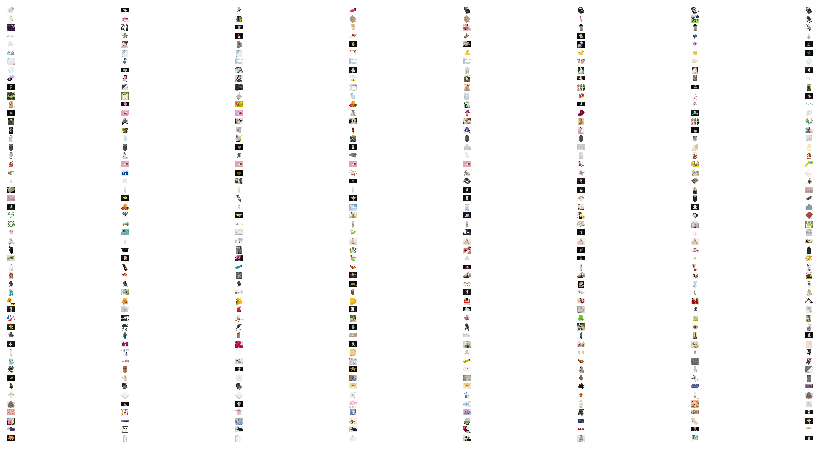

In [2]:
image_paths = glob.glob('FinalImages/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [3]:
image_path

'FinalImages\\986387_0.jpg'

In [4]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

100%|████████████████████████████████████████████████████████████████████████████████| 413/413 [06:35<00:00,  1.04it/s]


In [ ]:
#image_style_embeddings

In [5]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

# images mostly match the reference style, although not perfectly
# search_by_style('116066_0.jpg')
# search_by_style('s_cubism-02.jpg')

In [6]:
all_img = [a for a in images.keys()]

In [7]:
import pandas as pd
import numpy as np

In [8]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
    #a.append(sorted_neighbors[:11])
    #return a
#     f, ax = plt.subplots(1, max_results, figsize=(16, 8))
#     for i, img in enumerate(sorted_neighbors[:max_results]):
#         ax[i].imshow(images[img[0]])
#         ax[i].set_axis_off()
    
#     plt.show()

In [9]:
a = [search_by_style(image_name) for image_name in images.keys()]

In [10]:
# all_img.to_csv("a.csv")

In [10]:
search_by_style("6438372_1.jpg")

KeyError: '6438372_1.jpg'

In [11]:
b = pd.DataFrame(a)
b

,0,1,2,3,4,5,6,7,8,9,10
0,"(1006041_1.jpg, 0.0)","(1231297_0.jpg, 0.010955750942230225)","(964386_0.jpg, 0.012310504913330078)","(1154812_0.jpg, 0.01494753360748291)","(2157255_1.jpg, 0.015278637409210205)","(2157255_3.jpg, 0.016274631023406982)","(337044_0.jpg, 0.016808807849884033)","(1687893_1.jpg, 0.017093777656555176)","(1987193_0.jpg, 0.017311573028564453)","(964386_1.jpg, 0.01757735013961792)","(1468799_1.jpg, 0.017691075801849365)"
1,"(1008785_1.jpg, 0.0)","(1457890_0.jpg, 0.005957424640655518)","(402517_0.jpg, 0.006258189678192139)","(1906615_0.jpg, 0.006533801555633545)","(1590846_0.jpg, 0.006760120391845703)","(1953016_0.jpg, 0.00707244873046875)","(1968352_0.jpg, 0.007622122764587402)","(1132290_0.jpg, 0.00784081220626831)","(58054_0.jpg, 0.008195161819458008)","(358686_0.jpg, 0.008326828479766846)","(840601_0.jpg, 0.008448421955108643)"
2,"(1026722_0.jpg, 0.0)","(2034661_0.jpg, 0.025165915489196777)","(828127_0.jpg, 0.02550750970840454)","(650774_0.jpg, 0.026105105876922607)","(472850_0.jpg, 0.026342570781707764)","(321706_1.jpg, 0.026834309101104736)","(321706_2.jpg, 0.028418779373168945)","(321706_0.jpg, 0.028733491897583008)","(733529_2.jpg, 0.03103405237197876)","(733529_1.jpg, 0.03144550323486328)","(1529023_0.jpg, 0.03516024351119995)"
3,"(1026731_0.jpg, 0.0)","(1039403_0.jpg, 0.04195159673690796)","(263309_1.jpg, 0.04608947038650513)","(1486076_0.jpg, 0.048796772956848145)","(1440174_0.jpg, 0.049253642559051514)","(928673_0.jpg, 0.05267566442489624)","(263309_0.jpg, 0.05344301462173462)","(459246_0.jpg, 0.053611934185028076)","(1443668_1.jpg, 0.054824113845825195)","(1728638_1.jpg, 0.05513656139373779)","(659403_0.jpg, 0.05742752552032471)"
4,"(1030804_0.jpg, 0.0)","(1030804_1.jpg, 0.005405545234680176)","(1030804_3.jpg, 0.00564199686050415)","(1030804_2.jpg, 0.0638388991355896)","(1056191_1.jpg, 0.07782739400863647)","(1056191_3.jpg, 0.07866770029067993)","(733529_3.jpg, 0.08150792121887207)","(472850_0.jpg, 0.08770817518234253)","(238697_0.jpg, 0.08830678462982178)","(1529023_0.jpg, 0.08914607763290405)","(650774_0.jpg, 0.09881597757339478)"
...,...,...,...,...,...,...,...,...,...,...,...
408,"(977773_0.jpg, 0.0)","(2157255_3.jpg, 0.03940826654434204)","(70857_0.jpg, 0.04047048091888428)","(964386_0.jpg, 0.044621050357818604)","(660354_0.jpg, 0.044791996479034424)","(1084483_0.jpg, 0.04566013813018799)","(1760401_1.jpg, 0.04600238800048828)","(2158282_1.jpg, 0.04796409606933594)","(2158282_2.jpg, 0.04796409606933594)","(2158282_3.jpg, 0.04796409606933594)","(964386_1.jpg, 0.0503268837928772)"
409,"(982234_0.jpg, 0.0)","(1468799_1.jpg, 0.011993169784545898)","(1115571_2.jpg, 0.012112438678741455)","(1154812_0.jpg, 0.01538020372390747)","(2253353_0.jpg, 0.015896379947662354)","(1433731_0.jpg, 0.015927135944366455)","(1468799_2.jpg, 0.01620161533355713)","(687181_0.jpg, 0.016221821308135986)","(80746_0.jpg, 0.016893982887268066)","(797428_2.jpg, 0.01765543222427368)","(983256_0.jpg, 0.018031001091003418)"
410,"(982234_1.jpg, 0.0)","(797428_1.jpg, 0.024785935878753662)","(651751_1.jpg, 0.03485661745071411)","(750334_0.jpg, 0.03777521848678589)","(365129_2.jpg, 0.04329407215118408)","(982234_0.jpg, 0.04420191049575806)","(238697_1.jpg, 0.04528146982192993)","(1231297_0.jpg, 0.04688173532485962)","(1275914_0.jpg, 0.04741859436035156)","(1275914_1.jpg, 0.04741859436035156)","(1275914_2.jpg, 0.04741859436035156)"
411,"(983256_0.jpg, 0.0)","(986387_0.jpg, 0.003601670265197754)","(1732332_0.jpg, 0.005143463611602783)","(687181_0.jpg, 0.005623161792755127)","(1703449_1.jpg, 0.006076037883758545)","(756621_0.jpg, 0.0061743855476379395)","(2082446_0.jpg, 0.006342887878417969)","(1762430_0.jpg, 0.0063585638999938965)","(364512_0.jpg, 0.006884098052978516)","(2253353_0.jpg, 0.007034242153167725)","(2069608_0.jpg, 0.0072367191314697266)"


In [12]:
#Returns the first element of any list/tuple
def test(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [13]:
c = b.applymap(test)

In [14]:
c

,0,1,2,3,4,5,6,7,8,9,10
0,1006041_1.jpg,1231297_0.jpg,964386_0.jpg,1154812_0.jpg,2157255_1.jpg,2157255_3.jpg,337044_0.jpg,1687893_1.jpg,1987193_0.jpg,964386_1.jpg,1468799_1.jpg
1,1008785_1.jpg,1457890_0.jpg,402517_0.jpg,1906615_0.jpg,1590846_0.jpg,1953016_0.jpg,1968352_0.jpg,1132290_0.jpg,58054_0.jpg,358686_0.jpg,840601_0.jpg
2,1026722_0.jpg,2034661_0.jpg,828127_0.jpg,650774_0.jpg,472850_0.jpg,321706_1.jpg,321706_2.jpg,321706_0.jpg,733529_2.jpg,733529_1.jpg,1529023_0.jpg
3,1026731_0.jpg,1039403_0.jpg,263309_1.jpg,1486076_0.jpg,1440174_0.jpg,928673_0.jpg,263309_0.jpg,459246_0.jpg,1443668_1.jpg,1728638_1.jpg,659403_0.jpg
4,1030804_0.jpg,1030804_1.jpg,1030804_3.jpg,1030804_2.jpg,1056191_1.jpg,1056191_3.jpg,733529_3.jpg,472850_0.jpg,238697_0.jpg,1529023_0.jpg,650774_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...
408,977773_0.jpg,2157255_3.jpg,70857_0.jpg,964386_0.jpg,660354_0.jpg,1084483_0.jpg,1760401_1.jpg,2158282_1.jpg,2158282_2.jpg,2158282_3.jpg,964386_1.jpg
409,982234_0.jpg,1468799_1.jpg,1115571_2.jpg,1154812_0.jpg,2253353_0.jpg,1433731_0.jpg,1468799_2.jpg,687181_0.jpg,80746_0.jpg,797428_2.jpg,983256_0.jpg
410,982234_1.jpg,797428_1.jpg,651751_1.jpg,750334_0.jpg,365129_2.jpg,982234_0.jpg,238697_1.jpg,1231297_0.jpg,1275914_0.jpg,1275914_1.jpg,1275914_2.jpg
411,983256_0.jpg,986387_0.jpg,1732332_0.jpg,687181_0.jpg,1703449_1.jpg,756621_0.jpg,2082446_0.jpg,1762430_0.jpg,364512_0.jpg,2253353_0.jpg,2069608_0.jpg


In [15]:
c.to_csv("Method1.csv")